In [10]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from itertools import product
import ast
from collections import Counter
from sklearn.metrics import classification_report


# https://github.com/christinesako-berk/ds_207_final_project/blob/main/final_processing.ipynb OVIYA'S SAMPLE

In [ ]:
%cd /content/ds_207_final_project/data/processed

/content/ds_207_final_project/data/processed


In [ ]:
!ls

final_merged_2024.csv  final_merged_2025.csv


In [2]:
### Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


test_file = '/content/drive/My Drive/data/test_final.csv'
val_file = '/content/drive/My Drive/data/val_final.csv'
train_file = '/content/drive/My Drive/data/train_final.csv'


Mounted at /content/drive


In [3]:
test = pd.read_csv(test_file)
val = pd.read_csv(val_file)
train = pd.read_csv(train_file)

In [ ]:
test.shape

(103669, 458)

In [ ]:
val.shape

(54585, 458)

In [ ]:
train.shape

(218338, 458)

In [ ]:
train["ExtentOfInjuryCode"].value_counts()

,count
ExtentOfInjuryCode,
No Injury,134059
Minor,76242
Serious,6385
Fatal,1652


# EDA Assistance

In [ ]:
chunks = pd.read_csv("final_merged_2024.csv", chunksize=10000, engine="python", on_bad_lines='skip')
df = pd.concat(chunks, ignore_index=True)

Y = df[["ExtentOfInjuryCode"]]
X = df[["CollisionTypeDescription", "IsHighwayRelated", "Weather1", "RoadCondition1",
        "LightingDescription", "MovementPrecCollDescription", "AirbagDescription",
        "SafetyEquipmentDescription", "SobrietyDrugPhysicalDescription1", "SpeedLimit",
        "SpecialInformation"]]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1234)

In [ ]:
def extract_flattened_values(column):
  vals = []
  for val in X_train["MovementPrecCollDescription"]:
    if pd.isna(val):
      continue
    else:
      parsed = ast.literal_eval(val)
      if len(parsed) > 1:
        for v in parsed:
          vals.append(v)
      else:
        vals.append(parsed[0])
  return vals

In [ ]:
def plot_top_n_hist(column_data, title, top_n=10):
    flattened_vals = extract_flattened_values(column_data)
    val_counts = Counter(flattened_vals).most_common(top_n)

    labels, counts = zip(*val_counts)

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Count of Values in {title}")
    plt.xlabel(f"{title} Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

flattened_vals = extract_flattened_values("MovementPrecCollDescription")
plot_top_n_hist(X_train["MovementPrecCollDescription"], "MovementPrecCollDescription", top_n=len(set(flattened_vals)))

In [ ]:
import seaborn as sns
sns.boxplot(x='ExtentOfInjuryCode', y='SpeedLimit', data=pd.concat([X_train, Y_train], axis=1))
plt.title("Boxplot of Rating by Cocoa Level: 0=Low, 1=Medium, and 2=High")
plt.xlabel("Cocoa Level")
plt.ylabel("Chocolate Rating")
plt.show()
print("The boxplot of chocolate rating by cocoa level demonstrates that rating alone\n\
would be a difficult metric to distinguish the cocoa level groups, given that the\n\
distribution of ratings are around the same values.")

# Random Forest Model

## Loop Tuning - Randomized Grid

In [5]:
import random
# concat train and val for k-fold cross validation
df = pd.concat([train, val], axis=0).copy()

# transform extentofinjurycode to label 0,1,2,3
# set X features and Y target for model
label_encoder = LabelEncoder()
df["target"] = label_encoder.fit_transform(df["ExtentOfInjuryCode"])
X = df.drop(columns=["ExtentOfInjuryCode", "target"])
y = df["target"].values
class_names = label_encoder.classes_

# grid to explore
param_grid = {'n_estimators': np.arange(100, 200, 10),
              'max_depth': np.arange(20, 40, 5),
              'min_samples_split': [5],
              'min_samples_leaf': [1],
              'max_features': ['sqrt'],
              'use_pca': [False],
              'n_components': [None]}

# set random grid search
all_combinations = list(product(param_grid['n_estimators'],
                                param_grid['max_depth'],
                                param_grid['min_samples_split'],
                                param_grid['min_samples_leaf'],
                                param_grid['max_features'],
                                param_grid['use_pca']))

n_iter = 10
random.seed(42)
random_combos = random.sample(all_combinations, n_iter)

# hyperparameter tuning
results = []
for combo in random_combos:
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, use_pca = combo
    pca_components_list = param_grid["n_components"] if use_pca else [None]

    for n_components in pca_components_list:
        f1_scores = []
        acc_scores = []
        f1_per_class_all = []

        # split data into k folds (3 splits in data)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # run model for each split
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # include SMOTE to address class imbalance
            steps = [("smote", SMOTE(random_state=42))]
            if use_pca:
                steps += [("scaler", StandardScaler()), ("pca", PCA(n_components=n_components, random_state=42))]

            # use combo of parameters above to build classifier
            rf = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        max_features=max_features,
                                        class_weight="balanced",
                                        random_state=42,
                                        n_jobs=-1)

            # pipeline to handle sequence of operations: apply SMOTE, standardizes features and runs PCA, fits random forest
            steps.append(("rf", rf))
            pipeline = Pipeline(steps)
            pipeline.fit(X_train, y_train)
            preds = pipeline.predict(X_val)

            # get macro f1 score and accuracy scores
            f1_scores.append(f1_score(y_val, preds, average="macro"))
            acc_scores.append(accuracy_score(y_val, preds))

            # get f1 by class
            f1_per_class = f1_score(y_val, preds, average=None, labels=[0, 1, 2, 3])
            f1_per_class_all.append(f1_per_class)

        # average macro f1 score and average accuracy across folds
        avg_f1 = np.mean(f1_scores)
        avg_acc = np.mean(acc_scores)

        # average f1 score by class
        avg_f1_per_class = np.mean(f1_per_class_all, axis=0)

        results.append({"params": {"n_estimators": n_estimators,
                                  "max_depth": max_depth,
                                  "min_samples_split": min_samples_split,
                                  "min_samples_leaf": min_samples_leaf,
                                  "max_features": max_features,
                                  "use_pca": use_pca,
                                  "n_components": n_components if use_pca else None},
                        "f1_macro": avg_f1,
                        "accuracy": avg_acc,
                        "f1_classwise": dict(zip(class_names, avg_f1_per_class))})

        print(f"Tested config: {results[-1]['params']}")
        print(f"Macro F1: {avg_f1:.4f} | Accuracy: {avg_acc:.4f}")
        for class_label, score in zip(class_names, avg_f1_per_class):
            print(f"   - F1 [{class_label}]: {score:.4f}")
        print("oooooOOOOOoooooOOOOOOoooOOOOOOoooooOOOOOOOooooOOOOOOoooooOOOOO")

# get best results from model
results = sorted(results, key=lambda x: x["f1_classwise"]["Fatal"], reverse=True)
print("Best configuration (highest F1 for 'Fatal'):")
print(results[0])


Tested config: {'n_estimators': np.int64(110), 'max_depth': np.int64(35), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'use_pca': False, 'n_components': None}
Macro F1: 0.4374 | Accuracy: 0.6478
   - F1 [Fatal]: 0.2689
   - F1 [Minor]: 0.5478
   - F1 [No Injury]: 0.7525
   - F1 [Serious]: 0.1805
oooooOOOOOoooooOOOOOOoooOOOOOOoooooOOOOOOOooooOOOOOOoooooOOOOO
Tested config: {'n_estimators': np.int64(100), 'max_depth': np.int64(25), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'use_pca': False, 'n_components': None}
Macro F1: 0.4400 | Accuracy: 0.6414
   - F1 [Fatal]: 0.2752
   - F1 [Minor]: 0.5433
   - F1 [No Injury]: 0.7524
   - F1 [Serious]: 0.1891
oooooOOOOOoooooOOOOOOoooOOOOOOoooooOOOOOOOooooOOOOOOoooooOOOOO
Tested config: {'n_estimators': np.int64(140), 'max_depth': np.int64(25), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'use_pca': False, 'n_components': None}
Macro F1: 0.4404 | Accuracy: 0.6420
   - F1

## Run on Test

In [6]:
best_params = results[0]["params"]
use_pca = best_params["use_pca"]
n_components = best_params["n_components"]

# prepare data to run
X_full = X.copy()
y_full = y.copy()
X_test = test.drop(columns=["ExtentOfInjuryCode"]).copy()
y_test = label_encoder.transform(test["ExtentOfInjuryCode"])

# Create pipeline with same steps
steps = []

# SMOTE should NOT be used on test data
# Only applied during training, not evaluation

if use_pca:
    steps += [("scaler", StandardScaler()), ("pca", PCA(n_components=n_components, random_state=42))]

# Final classifier using best hyperparameters
rf = RandomForestClassifier(n_estimators=best_params["n_estimators"],
                            max_depth=best_params["max_depth"],
                            min_samples_split=best_params["min_samples_split"],
                            min_samples_leaf=best_params["min_samples_leaf"],
                            max_features=best_params["max_features"],
                            class_weight="balanced",
                            random_state=42,
                            n_jobs=-1)

steps.append(("rf", rf))
pipeline = Pipeline(steps)

# fit pipeline to full training data
pipeline.fit(X_full, y_full)

# predict on test data
y_pred = pipeline.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_per_class = f1_score(y_test, y_pred, average= None, labels=[0, 1, 2, 3])
fatal_index = list(class_names).index("Fatal")
f1_fatal = f1_per_class[fatal_index]

print("\n=== Final Evaluation on Test Set ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"F1 Score for 'Fatal': {f1_fatal:.4f}")



=== Final Evaluation on Test Set ===
Accuracy: 0.6552
Macro F1 Score: 0.4164
F1 Score for 'Fatal': 0.1671


In [4]:
class_names = label_encoder.classes_

print("\n=== Final Evaluation on Test Set ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")
for i, class_label in enumerate(class_names):
    print(f"F1 Score [{class_label}]: {f1_per_class[i]:.4f}")


=== Final Evaluation on Test Set ===
Accuracy: 0.6552
Macro F1 Score: 0.4164
F1 Score [Fatal]: 0.1671
F1 Score [Minor]: 0.5488
F1 Score [No Injury]: 0.7572
F1 Score [Serious]: 0.1926


## Feature Importance

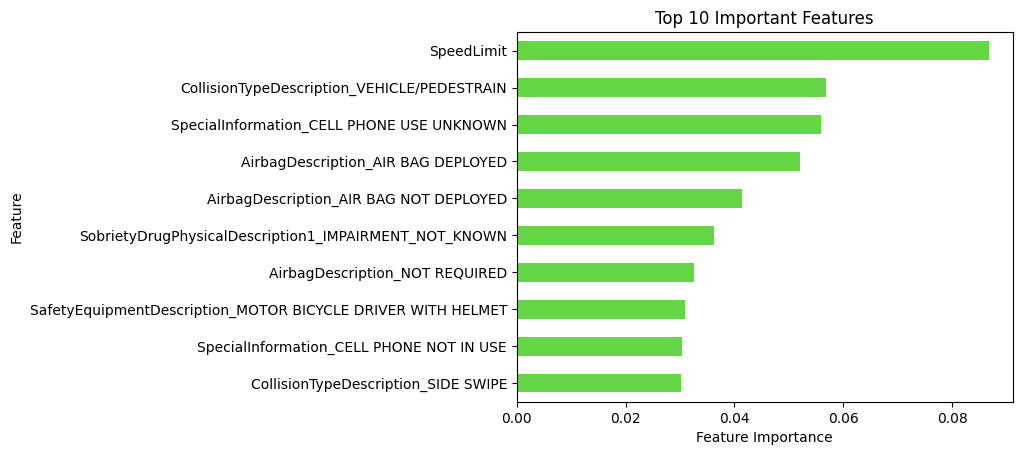

In [15]:
import matplotlib.pyplot as plt

# get the fitted RandomForest from the pipeline
rf_model = pipeline.named_steps["rf"]
feature_names = X.columns
importances = rf_model.feature_importances_

# create a sorted plot
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# plot top 10 important features
feat_imp.head(10).plot(kind="barh", color='#64D545')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()


# GitHub

In [ ]:
# Connect to GitHub Repo
from getpass import getpass

# Step 1: Enter token securely
token = getpass('Enter your GitHub token: ')

# Step 2: Build the full URL
repo_owner = "christinesako-berk"
repo_name = "ds_207_final_project"
repo_url = f"https://{token}@github.com/{repo_owner}/{repo_name}.git"

# Clone repo
!git clone "{repo_url}"

Enter your GitHub token: ··········
Cloning into 'ds_207_final_project'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 127 (delta 55), reused 39 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 11.30 MiB | 5.95 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Filtering content: 100% (6/6), 561.80 MiB | 36.63 MiB/s, done.


In [ ]:
%cd /content/ds_207_final_project/data/processed

/content/ds_207_final_project/data/processed


In [ ]:
!ls

final_merged_2024.csv  final_merged_2025.csv


In [ ]:
!git branch caitlin

In [ ]:
!git checkout caitlin

Switched to branch 'caitlin'


In [ ]:
!git status

On branch caitlin
nothing to commit, working tree clean
